# Installs & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from typing import List, Optional, Tuple
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('fivethirtyeight')
np.random.seed(42)

# Data Preparation

In [2]:
# Load U.S. macroeconomic data
macro_data = sm.datasets.macrodata.load_pandas().data

# Create a datetime index from 'year' and 'quarter'
macro_data['year'] = macro_data['year'].astype(int)
macro_data['quarter'] = macro_data['quarter'].astype(int)

# Use PeriodIndex.from_fields to avoid deprecation warnings
macro_data['date'] = pd.PeriodIndex.from_fields(year=macro_data['year'], quarter=macro_data['quarter']).to_timestamp()
macro_data.set_index('date', inplace=True)

# Select variables for analysis: realgdp, realcons, realinv, realgovt, infl, unemp
ts_data = macro_data[['realgdp', 'realcons', 'realinv', 'realgovt', 'infl', 'unemp']].dropna()

# Set a regular frequency (quarterly)
ts_data = ts_data.asfreq('QS')

print("Time Series Data:")
display(ts_data.head())

Time Series Data:


,realgdp,realcons,realinv,realgovt,infl,unemp
date,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,0.00,5.8
1959-04-01,2778.801,1733.7,310.859,481.301,2.34,5.1
1959-07-01,2775.488,1751.8,289.226,491.260,2.74,5.3
1959-10-01,2785.204,1753.7,299.356,484.052,0.27,5.6
1960-01-01,2847.699,1770.5,331.722,462.199,2.31,5.2


In [3]:
# Load Grunfeld investment data
grunfeld = sm.datasets.get_rdataset("Grunfeld", "plm").data

# Convert column names to lowercase for consistency
grunfeld.columns = grunfeld.columns.str.lower()

# The Grunfeld dataset has columns: firm, year, inv, value, capital
# Create an artificial treatment: let firm 1 be treated for years >= 1940
grunfeld['treatment_var'] = 0
grunfeld.loc[(grunfeld['firm'] == 1) & (grunfeld['year'] >= 1940), 'treatment_var'] = 1

# Create unit and time identifiers
grunfeld['unit'] = grunfeld['firm'].astype(str)
grunfeld['time'] = grunfeld['year']

print("Grunfeld Panel Data:")
display(grunfeld.head())

Grunfeld Panel Data:


,firm,year,inv,value,capital,treatment_var,unit,time
0,1,1935,317.6,3078.5,2.8,0,1,1935
1,1,1936,391.8,4661.7,52.6,0,1,1936
2,1,1937,410.6,5387.1,156.9,0,1,1937
3,1,1938,257.7,2792.2,209.2,0,1,1938
4,1,1939,330.8,4313.2,203.4,0,1,1939


# Granger Causality

In [4]:
class GrangerAnalysis:
    """
    Class to perform Granger causality tests on time series data.

    Attributes
    ----------
    data : pd.DataFrame
        DataFrame containing the time series data with required variables.
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data

    def test_granger_causality(self, variable1: str, variable2: str, max_lags: int = 12) -> pd.DataFrame:
        """
        Test for Granger causality between two variables.

        Parameters
        ----------
        variable1 : str
            Name of the first variable (e.g. dependent series)
        variable2 : str
            Name of the second variable (e.g. predictor series)
        max_lags : int, optional
            Maximum number of lags to test (default is 12)

        Returns
        -------
        pd.DataFrame
            DataFrame with F-statistics and p-values for each lag
        """
        for var in [variable1, variable2]:
            if var not in self.data.columns:
                raise ValueError(f"{var} is not a column in the data")

        # Use only the required columns and drop missing values
        data = self.data[[variable1, variable2]].dropna()

        # Call grangercausalitytests
        results = grangercausalitytests(data, maxlag=max_lags)

        causality_results = pd.DataFrame(index=range(1, max_lags + 1),
                                         columns=['F-statistic', 'p-value'])
        for lag in range(1, max_lags + 1):
            test_result = results[lag][0]['ssr_ftest']
            causality_results.loc[lag] = [test_result[0], test_result[1]]

        return causality_results

    def plot_causality_results(self, results: pd.DataFrame) -> None:
        """
        Plot the p-values for different lag orders.

        Parameters
        ----------
        results : pd.DataFrame
            DataFrame returned by test_granger_causality
        """
        plt.figure(figsize=(10, 6))
        plt.plot(results.index, results['p-value'], marker='o', color='navy')

        # Draw a horizontal line at the 5% significance level
        plt.axhline(y=0.05, color='red', linestyle='--', label='5% significance level')

        plt.xlabel('Lag Order')
        plt.ylabel('p-value')
        plt.title('Granger Causality Test Results')
        plt.legend()
        plt.grid(True)
        plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.1879  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1878  , p=0.6647  , df=1
parameter F test:         F=0.1851  , p=0.6675  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=47.0132 , p=0.0000  , df=2
likelihood ratio test: chi2=42.2456 , p=0.0000  , df=2
parameter F test:         F=22.9218 , p=0.0000  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.8505 , p=0.0000  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=64.8202 , p=0.0000  , df=3
likelihood ratio test: chi2=56.1467 , p=0.0000  , df=3
parameter F test:         F=20.8505 , p=0.0000  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=16.8883 , p=0.0000  

,F-statistic,p-value
1,0.185135,0.667463
2,22.921848,0.0
3,20.850482,0.0
4,16.888324,0.0
5,13.215711,0.0


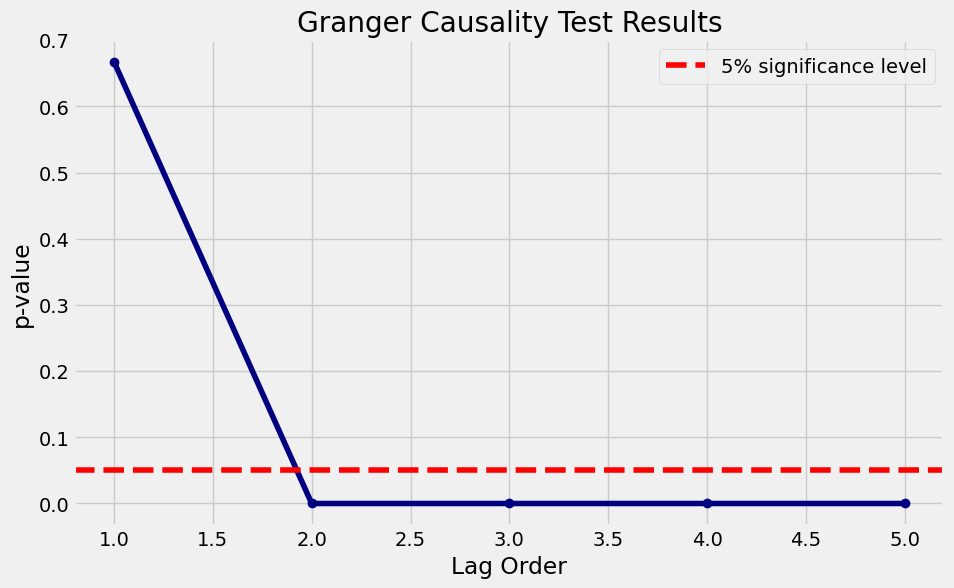

In [5]:
# Run Granger causality test: Does realcons Granger-cause realgdp?
ga = GrangerAnalysis(ts_data)

try:
    granger_results = ga.test_granger_causality('realgdp', 'realcons', max_lags=5)

    print("\nGranger Causality Test Results:")
    display(granger_results)
    print("\n")

    ga.plot_causality_results(granger_results)
except Exception as e:
    print(f"Error during Granger causality test: {e}")

# SVAR Model

In [6]:
class SVARModel:
    """
    Class to estimate a Structural VAR (SVAR) model using the VAR and SVAR classes.

    Attributes
    ----------
    data : pd.DataFrame
        DataFrame containing the time series variables for the SVAR estimation.
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data
        self.svar_results = None

    def fit(self, lags: int = 1, A: Optional[np.ndarray] = None, B: Optional[np.ndarray] = None):
        """
        Fit a structural VAR model with optional short-run (A) and long-run (B) restrictions.

        Parameters
        ----------
        lags : int, optional
            Number of lags to use (default is 1).
        A : Optional[np.ndarray], optional
            Short-run impact matrix with 'E' indicating parameters to estimate.
        B : Optional[np.ndarray], optional
            Long-run impact matrix with 'E' indicating parameters to estimate.

        Returns
        -------
        svar_results
            The fitted SVAR results object.
        """
        # Determine the number of variables
        n = self.data.shape[1]

        # Default: lower triangular A with ones on the diagonal and 'E' for free parameters below
        if A is None:
            A = np.eye(n, dtype=object)
            for i in range(n):
                for j in range(n):
                    if i > j:
                        A[i, j] = 'E'

        # Default: diagonal B with 'E' on the diagonal for free variance parameters
        if B is None:
            B = np.eye(n, dtype=object)
            for i in range(n):
                B[i, i] = 'E'

        # Ensure data has a proper frequency (quarterly in this case)
        if self.data.index.freq is None:
            self.data = self.data.asfreq('QS')

        # Create and fit the SVAR model
        try:
            self.svar_results = SVAR(self.data, svar_type='AB', A=A, B=B).fit(
                maxlags=lags, maxiter=10000, solver='lbfgs'
            )
        except Exception as e:
            raise RuntimeError(f"Error fitting SVAR model: {e}")

        return self.svar_results

    def impulse_response(self, periods: int = 20):
        """Calculate impulse response functions."""
        return self.svar_results.irf(periods=periods)

    def forecast_error_variance_decomposition(self, periods: int = 20):
        """Compute forecast error variance decomposition."""
        return self.svar_results.fevd(periods=periods)

In [7]:
def custom_irf_plot(irf):
    """
    Plot impulse responses manually from an IRF object.

    Parameters
    ----------
    irf : IRAnalysis
        The impulse response analysis object returned by SVARResults.irf().
    """
    # Extract the impulse responses; shape is (n_periods, n_endog, n_shocks)
    irfs = irf.irfs
    n_periods, n_endog, n_shocks = irfs.shape

    # Create one figure per response variable
    for response in range(n_endog):
        plt.figure(figsize=(8, 4))
        for shock in range(n_shocks):
            plt.plot(range(n_periods), irfs[:, response, shock],
                     label=f'Shock {shock+1}')
        plt.title(f'Impulse Responses of Variable {response+1}')
        plt.xlabel('Periods')
        plt.ylabel('Response')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [8]:
# Select two variables for SVAR analysis
svar_data = ts_data[['realgdp', 'realcons']]

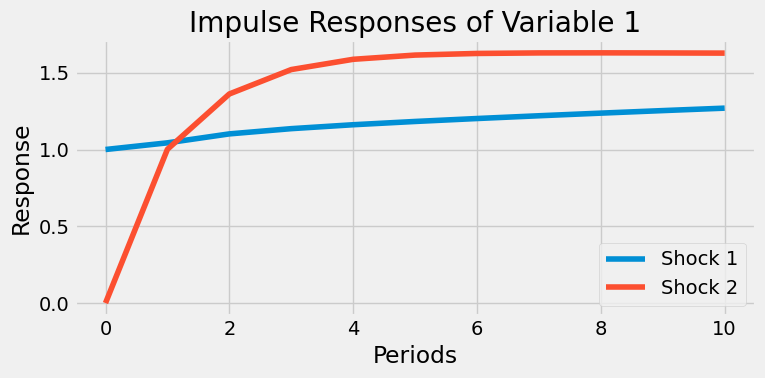

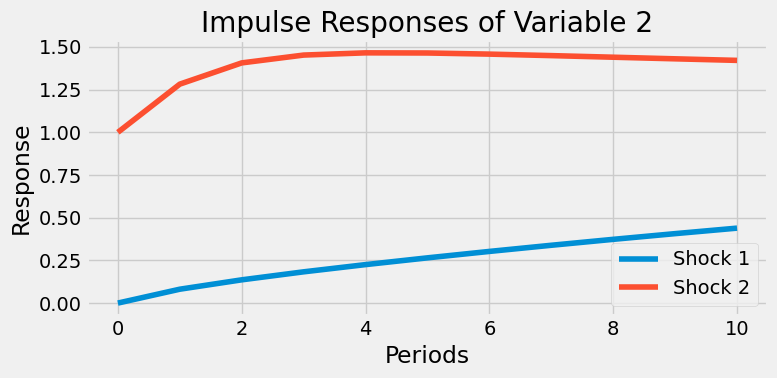

In [9]:
# Create and fit the SVAR model
try:
    svar_model = SVARModel(svar_data)
    svar_results = svar_model.fit(lags=2)

    # Impulse response analysis using the custom plotting function
    irf = svar_model.impulse_response(periods=10)
    custom_irf_plot(irf)

except Exception as e:
    print(f"Error: {e}")

# Local Projections

In [10]:
class LocalProjections:
    """
    Class to estimate impulse responses using local projections.

    Attributes
    ----------
    data : pd.DataFrame
        DataFrame containing the time series data
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data

    def estimate_impulse_response(self, dependent_var: str, shock_var: str,
                                  controls: Optional[List[str]] = None, horizons: int = 20
                                 ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Estimate impulse responses using local projections.

        Parameters
        ----------
        dependent_var : str
            Name of the dependent variable
        shock_var : str
            Shock variable whose coefficient represents the impulse response
        controls : Optional[List[str]], optional
            List of control variable names (default is None)
        horizons : int, optional
            Maximum horizon for impulse response estimation (default is 20)

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            (responses, confidence_intervals) for each horizon
        """
        for var in [dependent_var, shock_var]:
            if var not in self.data.columns:
                raise ValueError(f"{var} is not a column in the data")

        if controls is not None:
            for var in controls:
                if var not in self.data.columns:
                    raise ValueError(f"Control variable {var} is not in the data")

        responses = []
        confidence_intervals = []

        # Loop over horizons (each regression is independent)
        for h in range(horizons + 1):
            y = self.data[dependent_var].shift(-h)
            X = self.data[[shock_var]].copy()

            if controls is not None:
                X = pd.concat([X, self.data[controls]], axis=1)

            X = sm.add_constant(X)

            # Use HAC standard errors with maxlags equal to the horizon
            valid_idx = y.notna()
            y_h = y[valid_idx]
            X_h = X[valid_idx]

            try:
                model = sm.OLS(y_h, X_h)

                # Use HAC standard errors with maxlags equal to the horizon
                results = model.fit(cov_type='HAC', cov_kwds={'maxlags': h})
            except Exception as e:
                raise RuntimeError(f"Local projection regression failed at horizon {h}: {e}")

            responses.append(results.params[shock_var])

            # Save the lower and upper confidence bounds as a 2-element array
            confidence_intervals.append(results.conf_int().loc[shock_var].values)

        return np.array(responses), np.array(confidence_intervals)

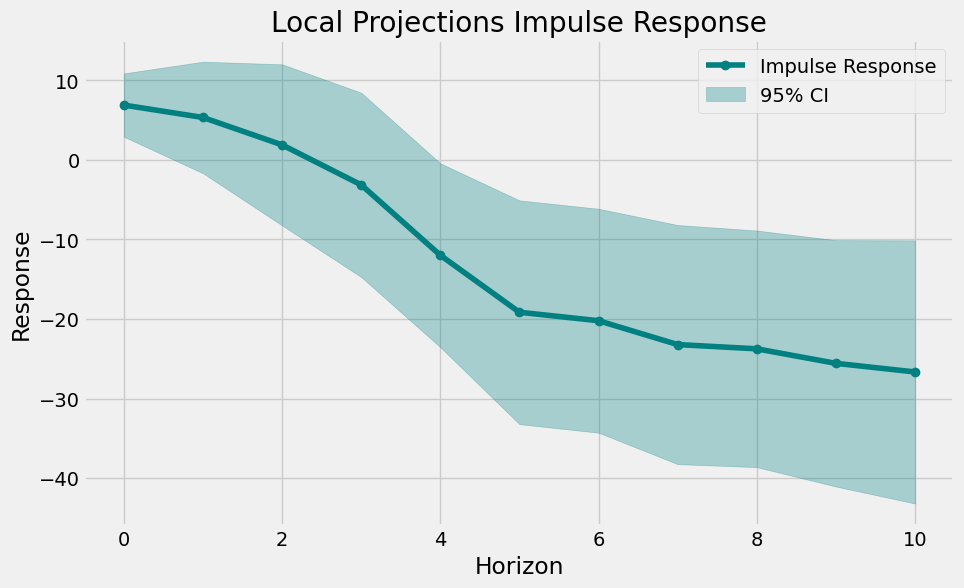

In [11]:
# Estimate the impulse response of realgdp to an inflation shock,
# controlling for realcons and realinv using local projections
try:
    lp = LocalProjections(ts_data)
    lp_response, lp_conf_int = lp.estimate_impulse_response(
        dependent_var='realgdp',
        shock_var='infl',
        controls=['realcons', 'realinv'],
        horizons=10
    )

    # Plot point estimates with 95% confidence intervals
    horizons = np.arange(0, len(lp_response))
    plt.figure(figsize=(10, 6))
    plt.plot(horizons, lp_response, marker='o', color='teal', label='Impulse Response')

    lower = lp_conf_int[:, 0]
    upper = lp_conf_int[:, 1]
    plt.fill_between(horizons, lower, upper, color='teal', alpha=0.3, label='95% CI')

    plt.xlabel('Horizon')
    plt.ylabel('Response')
    plt.title('Local Projections Impulse Response')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error during local projections estimation: {e}")

# IV Regression

In [12]:
class TSInstrumentalVariables:
    """
    Class to perform time series instrumental variables regression using a two-stage procedure.

    Attributes
    ----------
    data : pd.DataFrame
        DataFrame containing the time series data
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data

    def estimate_iv(self, dependent_var: str, endogenous_var: str, instrument_var: str,
                    controls: Optional[List[str]] = None
                   ) -> Tuple[sm.regression.linear_model.RegressionResultsWrapper,
                              sm.regression.linear_model.RegressionResultsWrapper]:
        """
        Estimate an IV regression using a two-stage procedure.

        Parameters
        ----------
        dependent_var : str
            Outcome variable name
        endogenous_var : str
            Endogenous variable to be instrumented
        instrument_var : str
            Instrument variable name
        controls : Optional[List[str]], optional
            Additional control variable names (default is None)

        Returns
        -------
        Tuple[first_stage, second_stage]
            First stage and second stage regression results
        """
        for var in [dependent_var, endogenous_var, instrument_var]:
            if var not in self.data.columns:
                raise ValueError(f"{var} is not a column in the data")

        if controls is not None:
            for var in controls:
                if var not in self.data.columns:
                    raise ValueError(f"Control variable {var} is not in the data")

        # Ensure instrument is passed as a DataFrame (double brackets)
        X_first = sm.add_constant(self.data[[instrument_var]])

        if controls is not None:
            X_first = pd.concat([X_first, self.data[controls]], axis=1)

        first_stage = sm.OLS(self.data[endogenous_var], X_first).fit()
        fitted_values = first_stage.predict()

        # Convert fitted values to a DataFrame so that concatenation works properly
        fitted_df = pd.DataFrame(fitted_values, index=self.data.index, columns=['fitted'])
        X_second = sm.add_constant(fitted_df)

        if controls is not None:
            X_second = pd.concat([X_second, self.data[controls]], axis=1)

        second_stage = sm.OLS(self.data[dependent_var], X_second).fit()

        return first_stage, second_stage

In [13]:
# Instrument realinv (endogenous) for realcons using realgovt as instrument,
# controlling for infl and unemp
try:
    tiv = TSInstrumentalVariables(ts_data)
    first_stage, second_stage = tiv.estimate_iv(
        dependent_var='realcons',
        endogenous_var='realinv',
        instrument_var='realgovt',
        controls=['infl', 'unemp']
    )

    print("Time Series IV - First Stage Regression Summary:")
    print(first_stage.summary())

    print("\nTime Series IV - Second Stage Regression Summary:")
    print(second_stage.summary())
except Exception as e:
    print(f"Error during IV regression: {e}")

Time Series IV - First Stage Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                realinv   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           1.17e-46
Time:                        09:31:51   Log-Likelihood:                -1470.9
No. Observations:                 203   AIC:                             2950.
Df Residuals:                     199   BIC:                             2963.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

# Double ML

In [14]:
class ModernCausalInference:
    """
    Class to implement double machine learning for causal inference.

    Attributes
    ----------
    data : pd.DataFrame
        DataFrame containing the variables
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data

    def double_machine_learning(self, y: str, d: str, x: List[str],
                                ml_model: Optional[RandomForestRegressor] = None
                               ) -> sm.regression.linear_model.RegressionResultsWrapper:
        """
        Implement double machine learning for causal inference.

        Parameters
        ----------
        y : str
            Outcome variable name
        d : str
            Treatment variable name
        x : List[str]
            List of control variable names
        ml_model : Optional[RandomForestRegressor], optional
            Machine learning model for residualization (default is RandomForestRegressor)

        Returns
        -------
        RegressionResultsWrapper
            OLS regression results on the residuals
        """
        for var in [y, d] + x:
            if var not in self.data.columns:
                raise ValueError(f"{var} is not a column in the data")

        if ml_model is None:
            ml_model = RandomForestRegressor(n_estimators=100, random_state=42)

        # First stage: predict treatment using controls
        ml_model.fit(self.data[x], self.data[d])
        d_hat = ml_model.predict(self.data[x])

        # Second stage: predict outcome using controls
        ml_model.fit(self.data[x], self.data[y])
        y_hat = ml_model.predict(self.data[x])

        residualized_y = self.data[y] - y_hat
        residualized_d = self.data[d] - d_hat

        treatment_effect = sm.OLS(residualized_y, residualized_d).fit()
        return treatment_effect

In [15]:
# Estimate the effect of inflation on realgdp using double machine learning,
# controlling for realcons and realinv
try:
    mci = ModernCausalInference(ts_data)
    dml_results = mci.double_machine_learning('realgdp', 'infl', ['realcons', 'realinv'])

    print("Double Machine Learning Regression Summary:")
    print(dml_results.summary())
except Exception as e:
    print(f"Error during double machine learning estimation: {e}")

Double Machine Learning Regression Summary:
                                 OLS Regression Results                                
Dep. Variable:                realgdp   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.010
Date:                Sun, 09 Feb 2025   Prob (F-statistic):                       0.316
Time:                        09:31:52   Log-Likelihood:                         -873.01
No. Observations:                 203   AIC:                                      1748.
Df Residuals:                     202   BIC:                                      1751.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.97

# Dynamic DID

In [16]:
class DynamicDiD:
    """
    Class to estimate dynamic difference-in-differences for panel data using an event-study framework.

    Attributes
    ----------
    data : pd.DataFrame
        Panel data with outcome, treatment, and identifier columns.
    """
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError("data must be a pandas DataFrame")
        self.data = data.copy()

    def estimate_dynamic_effects(self, outcome_var: str, treatment_var: str,
                                 unit_col: str = 'unit', time_col: str = 'time',
                                 event_window: range = range(-4, 5), omit_event: int = -1
                                ) -> sm.regression.linear_model.RegressionResultsWrapper:
        """
        Estimate dynamic treatment effects using an event-study framework by creating event-time indicators.

        Parameters
        ----------
        outcome_var : str
            Name of the outcome variable.
        treatment_var : str
            Name of the treatment variable.
        unit_col : str, optional
            Column name for unit identifier (default 'unit').
        time_col : str, optional
            Column name for time identifier (default 'time').
        event_window : range, optional
            Range of event times to consider (default range(-4, 5)).
        omit_event : int, optional
            The event time to omit as the baseline period (default -1).

        Returns
        -------
        RegressionResultsWrapper
            Regression results with clustered standard errors by unit.
        """
        # For each unit, determine the first time period in which treatment occurs
        first_treatment = self.data[self.data[treatment_var] == 1].groupby(unit_col)[time_col].min().rename('first_treatment_time')

        # Merge first treatment time into the main data
        self.data = self.data.merge(first_treatment, on=unit_col, how='left')

        # Create an event_time variable: current time minus first_treatment_time
        # For never-treated units, first_treatment_time is missing; fill event_time with a placeholder (-999)
        self.data['event_time'] = self.data[time_col] - self.data['first_treatment_time']
        self.data['event_time'] = self.data['event_time'].fillna(-999)

        # Create event-study dummy variables for each event time in the specified window (omitting the baseline)
        # Use valid variable names: for negative event times use "event_m{abs(event_time)}", for nonnegative use "event_p{event_time}"
        dummy_names = {}
        for et in event_window:
            if et == omit_event:
                continue  # omit the baseline period for identification
            if et < 0:
                dummy_name = f"event_m{abs(et)}"
            else:
                dummy_name = f"event_p{et}" if et > 0 else "event_0"
            dummy_names[et] = dummy_name
            self.data[dummy_name] = (self.data['event_time'] == et).astype(int)

        # Construct the regression formula:
        # Outcome is regressed on the event dummy variables plus unit and time fixed effects
        event_terms = " + ".join(dummy_names[et] for et in sorted(dummy_names.keys()))
        formula = f"{outcome_var} ~ {event_terms} + C({unit_col}) + C({time_col})"

        # Estimate the model using OLS with cluster robust standard errors (clustering by unit)
        model = sm.OLS.from_formula(formula, data=self.data)
        results = model.fit(cov_type='cluster', cov_kwds={'groups': self.data[unit_col]})
        return results

In [17]:
# Apply dynamic difference-in-differences using the DynamicDiD class
try:
    dd = DynamicDiD(grunfeld)
    did_results = dd.estimate_dynamic_effects(
        outcome_var='inv',
        treatment_var='treatment_var',
        unit_col='unit',
        time_col='time',
        event_window=range(-4, 5),  # Event window from -4 to 4
        omit_event=-1               # Use event time -1 as the baseline period
    )

    print("Dynamic Difference-in-Differences Regression Summary:")
    print(did_results.summary())
except Exception as e:
    print(f"Error during dynamic DiD estimation: {e}")

Dynamic Difference-in-Differences Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                    inv   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1005.
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           2.03e-12
Time:                        09:31:52   Log-Likelihood:                -1161.7
No. Observations:                 200   AIC:                             2397.
Df Residuals:                     163   BIC:                             2519.
Df Model:                          36                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 9
  warnings.warn('covariance of constraints does not have full '


# Synthetic Control

In [18]:
class SyntheticControl:
    """
    Class to construct a synthetic control for panel data analysis.

    Attributes
    ----------
    data : pd.DataFrame
        Panel data with time as index and a column named 'unit'
    treatment_unit : str
        Identifier for the treated unit (e.g., 'Firm1')
    control_units : List[str]
        List of control unit identifiers
    treatment_period : float or int
        Time threshold (e.g., year) for pre-treatment matching
    outcome_var : str
        Name of the outcome variable to match
    """
    def __init__(self, data: pd.DataFrame, treatment_unit: str, control_units: List[str],
                 treatment_period, outcome_var: str):
        if outcome_var not in data.columns:
            raise ValueError(f"{outcome_var} must be in the data")
        if 'unit' not in data.columns:
            raise ValueError("Data must contain a 'unit' column")

        self.data = data
        self.treatment_unit = treatment_unit
        self.control_units = control_units
        self.treatment_period = treatment_period
        self.outcome_var = outcome_var

    def construct_synthetic_control(self) -> np.ndarray:
        """
        Construct synthetic control by finding optimal weights on control units to best match
        the treated unit in the pre-treatment period.

        Returns
        -------
        np.ndarray
            Array of optimal weights for the control units
        """
        pre_treatment = self.data[self.data.index < self.treatment_period]

        control_series = []
        for u in self.control_units:
            series = pre_treatment.loc[pre_treatment['unit'] == u, self.outcome_var].values
            control_series.append(series)

        # Stack control series as columns; all series must have the same length
        control_matrix = np.column_stack(control_series)

        treated = pre_treatment.loc[pre_treatment['unit'] == self.treatment_unit, self.outcome_var].values
        if treated.shape[0] != control_matrix.shape[0]:
            raise ValueError("Mismatch in time dimensions between treated and control units")

        def objective(weights: np.ndarray) -> float:
            synthetic = np.dot(control_matrix, weights)
            return np.mean((treated - synthetic) ** 2)

        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda w: w}
        ]

        result = minimize(objective,
                          x0=np.ones(len(self.control_units)) / len(self.control_units),
                          constraints=constraints,
                          method='SLSQP')
        if not result.success:
            raise RuntimeError("Synthetic control optimization did not converge")

        return result.x

Synthetic Control Weights for the Control Units:
Firm4: -0.000
Firm8: 0.000
Firm2: 1.000
Firm6: -0.000
Firm10: 0.000
Firm3: 0.000
Firm5: 0.000
Firm9: -0.000
Firm7: -0.000




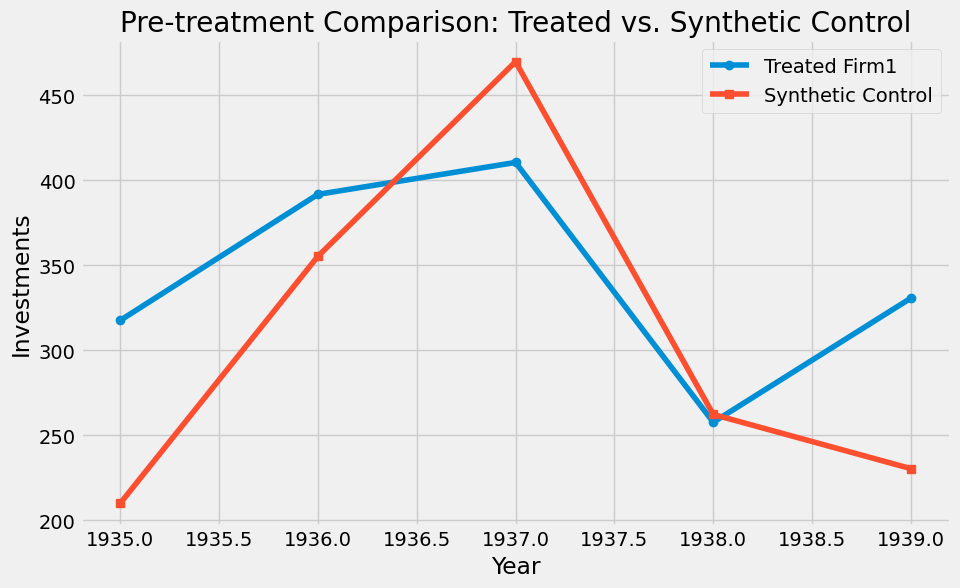

In [19]:
# Copy the panel data
sc_data = grunfeld.copy()

# Create a unit identifier string ('Firm1', 'Firm2', etc.)
sc_data['unit'] = 'Firm' + sc_data['firm'].astype(str)

# Sort by year and set the index to year
sc_data = sc_data.sort_values(by=['year'])
sc_data.set_index('year', inplace=True)

# Define treatment unit and control units
treatment_unit = 'Firm1'
control_units = sc_data['unit'].unique().tolist()
if treatment_unit in control_units:
    control_units.remove(treatment_unit)

treatment_period = 1940  # Use years before 1940 as the pre-treatment period

try:
    # Use 'inv' as the outcome variable
    sc_model = SyntheticControl(data=sc_data,
                                treatment_unit=treatment_unit,
                                control_units=control_units,
                                treatment_period=treatment_period,
                                outcome_var='inv')

    synthetic_weights = sc_model.construct_synthetic_control()

    print("Synthetic Control Weights for the Control Units:")
    for unit, weight in zip(control_units, synthetic_weights):
        print(f"{unit}: {weight:.3f}")
    print("\n")

    # Plot pre-treatment trajectories for the treated unit and its synthetic control
    pre_treatment = sc_data[sc_data.index < treatment_period]
    treated_series = pre_treatment.loc[pre_treatment['unit'] == treatment_unit, 'inv']

    # Build synthetic control series as weighted sum of control units
    control_dict = {}
    for i, unit in enumerate(control_units):
        series = pre_treatment.loc[pre_treatment['unit'] == unit, 'inv']
        control_dict[unit] = series * synthetic_weights[i]

    synthetic_series = pd.DataFrame(control_dict).sum(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(treated_series.index, treated_series, label=f"Treated {treatment_unit}", marker='o')
    plt.plot(synthetic_series.index, synthetic_series, label="Synthetic Control", marker='s')
    plt.xlabel("Year")
    plt.ylabel("Investments")
    plt.title("Pre-treatment Comparison: Treated vs. Synthetic Control")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error during synthetic control estimation: {e}")